In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(instance='ibm-q/open/main')
backends = service.backends()
print(backends)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>]


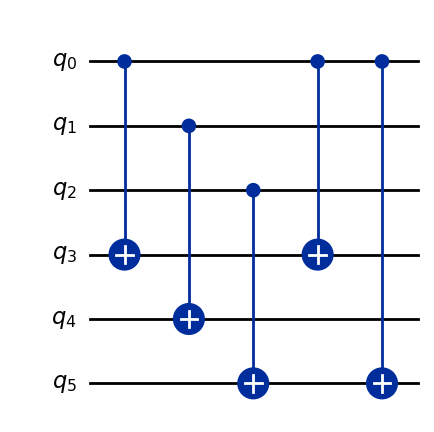

In [24]:
#pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
#example of oracle from simon_oracle library
from qiskit_textbook.tools import simon_oracle

s = '101'
simon_oracle(s).draw('mpl')

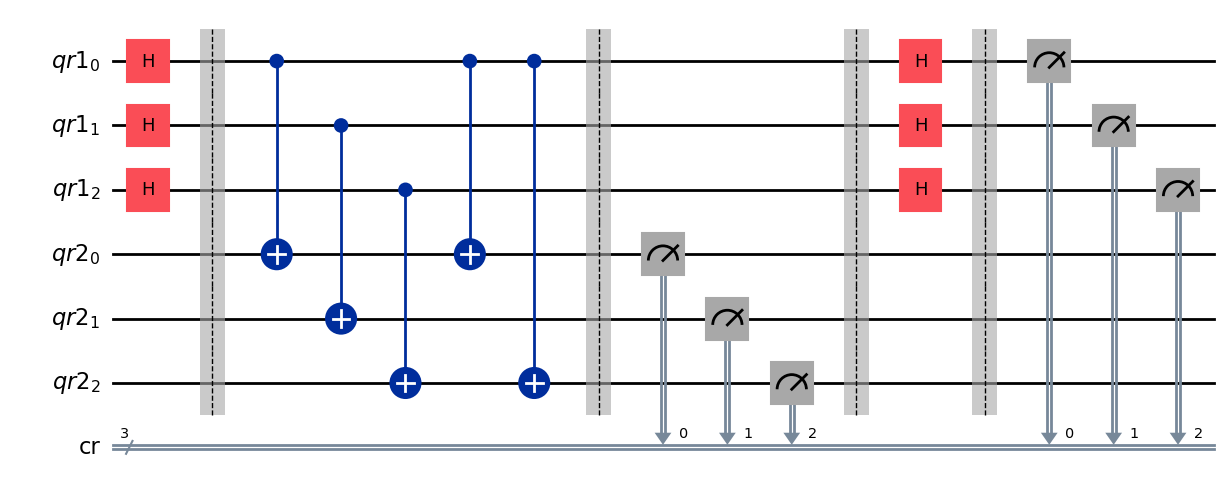

In [25]:
#first implentation of oracle
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

qc.h(qr1)
qc.barrier()

# copying the data of first register to second register
qc.cx(qr1, qr2)
# applying bit wise X-OR from register 1 to register 2 where qubits of first register is 1
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
qc.barrier()

qc.measure(qr2, cr)
qc.barrier()

qc.h(qr1)
qc.barrier()

qc.measure(qr1, cr)

qc.draw('mpl')

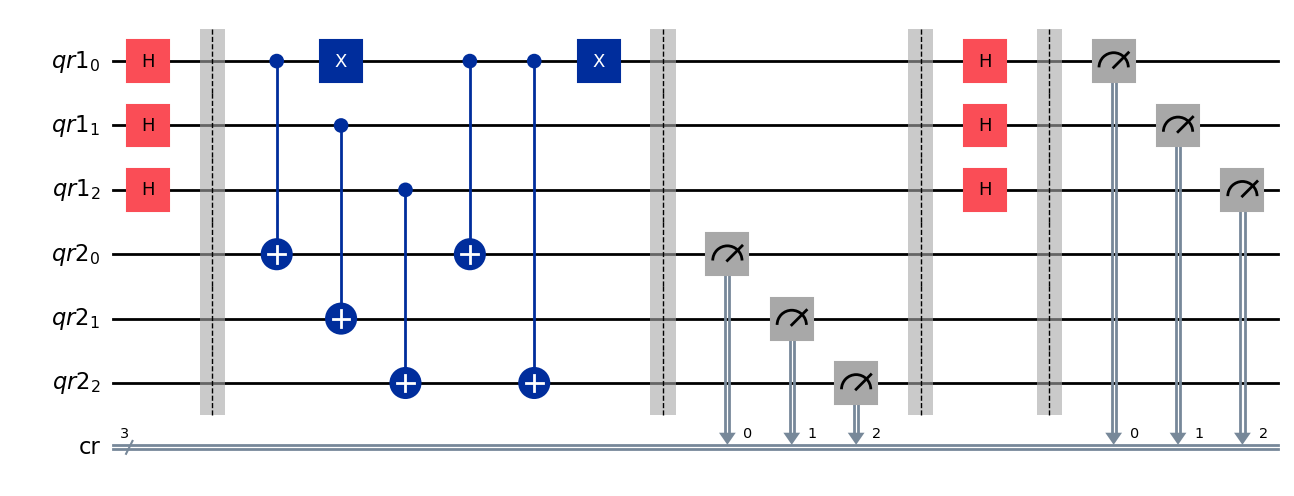

In [26]:
#a different way of implementing the oracle with X gates
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

qc.h(qr1)
qc.barrier()

# copying the data of first register to second register
qc.cx(qr1, qr2)
# applying bit wise X-OR from register 1 to register 2 where qubits of first register is 1
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
        qc.x(qr1[firstOne])
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
if firstOne != -1:
    qc.x(qr1[firstOne])
qc.barrier()

qc.measure(qr2, cr)
qc.barrier()

qc.h(qr1)
qc.barrier()

qc.measure(qr1, cr)

qc.draw('mpl')

C:\Users\szaro\AppData\Local\Temp\ipykernel_46772\569822248.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = sim.run(job).result()


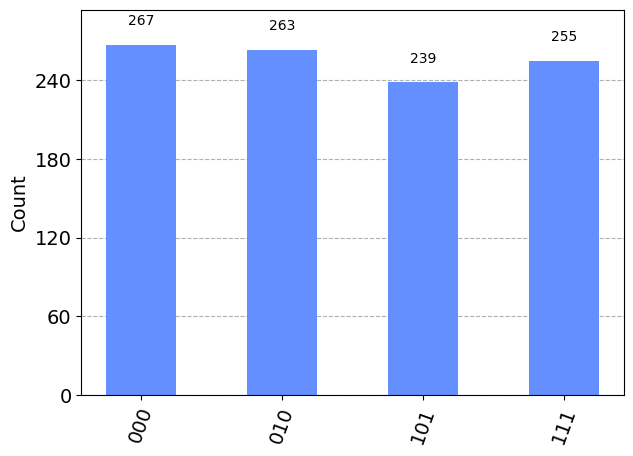

In [27]:
#running the circuit
from qiskit_aer import QasmSimulator
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram

sim = QasmSimulator()
job = assemble(qc, sim)
result = sim.run(job).result()
counts = result.get_counts()
plot_histogram(counts)

In [28]:
#finding output values
import numpy as np

# generating all possible binary strings of length n
def generate_binary(n):
    for i in range(2**n):
        yield format(i, '0{}b'.format(n))

# finding probable bits
def findImportantBits(counts):
    for binary_string in generate_binary(n):
        if counts.get(binary_string, 0) > 0:
            yield binary_string
    return None

vals = []
for binary_string in findImportantBits(counts):
    if (binary_string == '0' * n):
        continue
    print(binary_string)
    vals.append( [ int(c) for c in binary_string ] )
numVals = len(vals)

010
101
111


In [29]:
#solving system of equations
#FOUND FROM https://github.com/amazon-braket/amazon-braket-examples/blob/f49bb6a68f1be280e4b00146022c35a5293d2f07/examples/advanced_circuits_algorithms/Simons_Algorithm/Simons_Algorithm.ipynb

from sympy import Matrix
    
print('The result in matrix form is :')
for a in vals:
    print (a)

M=Matrix(vals).T

# Construct the agumented matrix
M_I = Matrix(np.hstack([M,np.eye(M.shape[0],dtype=int)]))

# Perform row reduction, working modulo 2. We use the iszerofunc property of rref
# to perform the Gaussian elimination over the finite field.
M_I_rref = M_I.rref(iszerofunc=lambda x: x % 2==0)

# In row reduced echelon form, we can end up with a solution outside of the finite field {0,1}.
# Thus, we need to revert the matrix back to this field by treating fractions as a modular inverse.
# Since the denominator will always be odd (i.e. 1 mod 2), it can be ignored.

# Helper function to treat fractions as modular inverse:
def mod2(x):
    return x.as_numer_denom()[0] % 2

# Apply our helper function to the matrix
M_I_final = M_I_rref[0].applyfunc(mod2)

# Extract the kernel of M from the remaining columns of the last row, when s is nonzero.
if all(value == 0 for value in M_I_final[-1,:M.shape[1]]):
    result_s="".join(str(c) for c in M_I_final[-1,M.shape[1]:])

# Otherwise, the sub-matrix will be full rank, so just set s=0...0
else:
    result_s='0'*M.shape[0]

# Check whether result_s is equal to initial s:
print ('Secret string: ' + s)
print ('Result string: ' + result_s)
if (result_s == s):
    print ('We found the correct answer.')
else:
    print ('Error. The answer is wrong!')

The result in matrix form is :
[0, 1, 0]
[1, 0, 1]
[1, 1, 1]
Secret string: 101
Result string: 101
We found the correct answer.
